`pip install transformers`


In [2]:
from transformers import GLPNFeatureExtractor, GLPNForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests
import matplotlib
import matplotlib.pyplot as plt
import open3d as o3d
matplotlib.use('TkAgg')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [10]:

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = GLPNFeatureExtractor.from_pretrained("vinvino02/glpn-nyu")
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")


In [ ]:

# prepare image for the model
inputs = feature_extractor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().to('cpu').numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

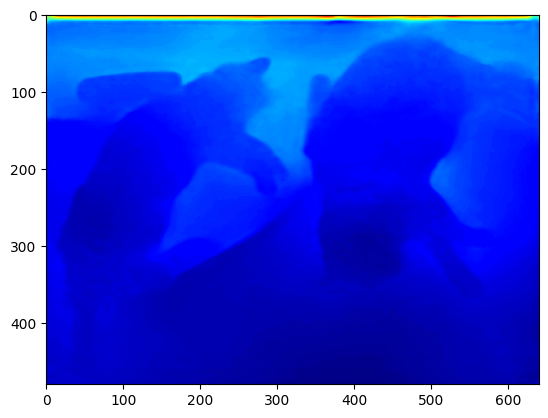

In [36]:
plt.imshow(depth, cmap="jet")

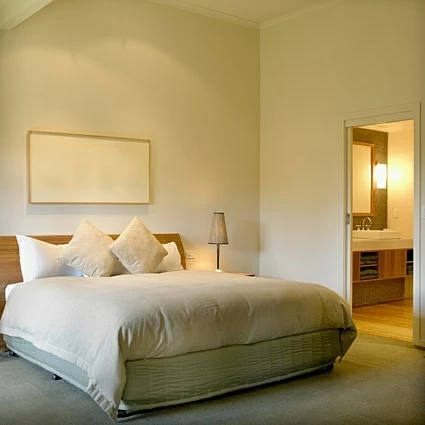

In [8]:
url = 'https://images.all-free-download.com/images/graphicwebp/simple_room_picture_167607.webp'
image = Image.open(requests.get(url, stream=True).raw)
image

In [21]:
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 416, 416])


In [22]:
with torch.no_grad():
  outputs = model(pixel_values)
  predicted_depth = outputs.predicted_depth

In [25]:
predicted_depth

tensor([[[4.6627, 4.5064, 4.4821,  ..., 4.2576, 4.3672, 4.6249],
         [4.3732, 4.0182, 3.8562,  ..., 3.5469, 3.7351, 4.1147],
         [4.6811, 4.5537, 4.4654,  ..., 3.9968, 4.1732, 4.2776],
         ...,
         [2.6739, 2.6857, 2.6927,  ..., 2.7372, 2.7384, 2.7464],
         [2.7407, 2.6545, 2.7182,  ..., 2.7419, 2.8083, 2.7292],
         [2.8145, 2.7869, 2.6978,  ..., 2.7022, 2.7182, 2.7981]]])

In [24]:
predicted_depth.unsqueeze(1)

tensor([[[[4.6627, 4.5064, 4.4821,  ..., 4.2576, 4.3672, 4.6249],
          [4.3732, 4.0182, 3.8562,  ..., 3.5469, 3.7351, 4.1147],
          [4.6811, 4.5537, 4.4654,  ..., 3.9968, 4.1732, 4.2776],
          ...,
          [2.6739, 2.6857, 2.6927,  ..., 2.7372, 2.7384, 2.7464],
          [2.7407, 2.6545, 2.7182,  ..., 2.7419, 2.8083, 2.7292],
          [2.8145, 2.7869, 2.6978,  ..., 2.7022, 2.7182, 2.7981]]]])

In [26]:
predicted_depth.shape

torch.Size([1, 416, 416])

In [27]:
predicted_depth.unsqueeze(1).shape

torch.Size([1, 1, 416, 416])

In [28]:
pixel_values.shape[-2:]

torch.Size([416, 416])

In [29]:
# interpolate to original size
prediction = torch.nn.functional.interpolate(
                    predicted_depth.unsqueeze(1),
                    size=pixel_values.shape[-2:],
                    mode="bicubic",
                    align_corners=False,
             )
prediction = prediction.squeeze().cpu().numpy()

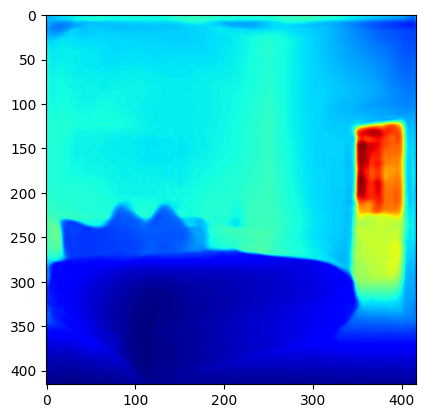

In [31]:
plt.imshow(prediction, cmap="jet")

In [11]:
image = Image.open('photo_2022-11-03_18-56-00.jpg')

In [12]:

# load and resize the input image
new_height = 480 if image.height > 480 else image.height
new_height -= (new_height % 32)
new_width = int(new_height * image.width / image.height)
diff = new_width % 32
new_width = new_width - diff if diff < 16 else new_width + 32 - diff
new_size = (new_width, new_height)
image = image.resize(new_size)


In [13]:
new_size

(352, 480)

In [17]:

# prepare image for the model
inputs = feature_extractor(images=image, return_tensors="pt")

# get the prediction from the model
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# remove borders
pad = 16
output = predicted_depth.squeeze().cpu().numpy() * 1000.0
output = output[pad:-pad, pad:-pad]
image = image.crop((pad, pad, image.width - pad, image.height - pad))

# visualize the prediction
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax[1].imshow(output, cmap='plasma')
ax[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.tight_layout()
plt.pause(5)


In [18]:

width, height = image.size

depth_image = (output * 255 / np.max(output)).astype('uint8')
image = np.array(image)

# create rgbd image
depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(image)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d, depth_o3d, convert_rgb_to_intensity=False)

# camera settings
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(width, height, 500, 500, width/2, height/2)

# create point cloud
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)

In [19]:
# для визуализации
o3d.visualization.draw_geometries([pcd])

In [20]:
# outliers removal
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=20.0)
pcd = pcd.select_by_index(ind)


In [21]:

# estimate normals
pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()

# surface reconstruction
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=10, n_threads=1)[0]

# rotate the mesh
rotation = mesh.get_rotation_matrix_from_xyz((np.pi, 0, 0))
mesh.rotate(rotation, center=(0, 0, 0))

# save the mesh
o3d.io.write_triangle_mesh(f'./mesh.obj', mesh)

True